# Transformer와 GPT-1 비교

#### 1. Decoder-Only Transformer
    - GPT-1은 인코더 없이 디코더만 있는 구조이다.
    - 따라서 Self-Attention만 존재하며, 인-디코더간 Cross-Attention은 없다.
#### 2. Positional Embedding
    - 기존 Transformer처럼 주기함수 기반 Positional Encoding이 아니라, 학습 가능한 Positional Embedding을 사용한다.

# model.summary 결과
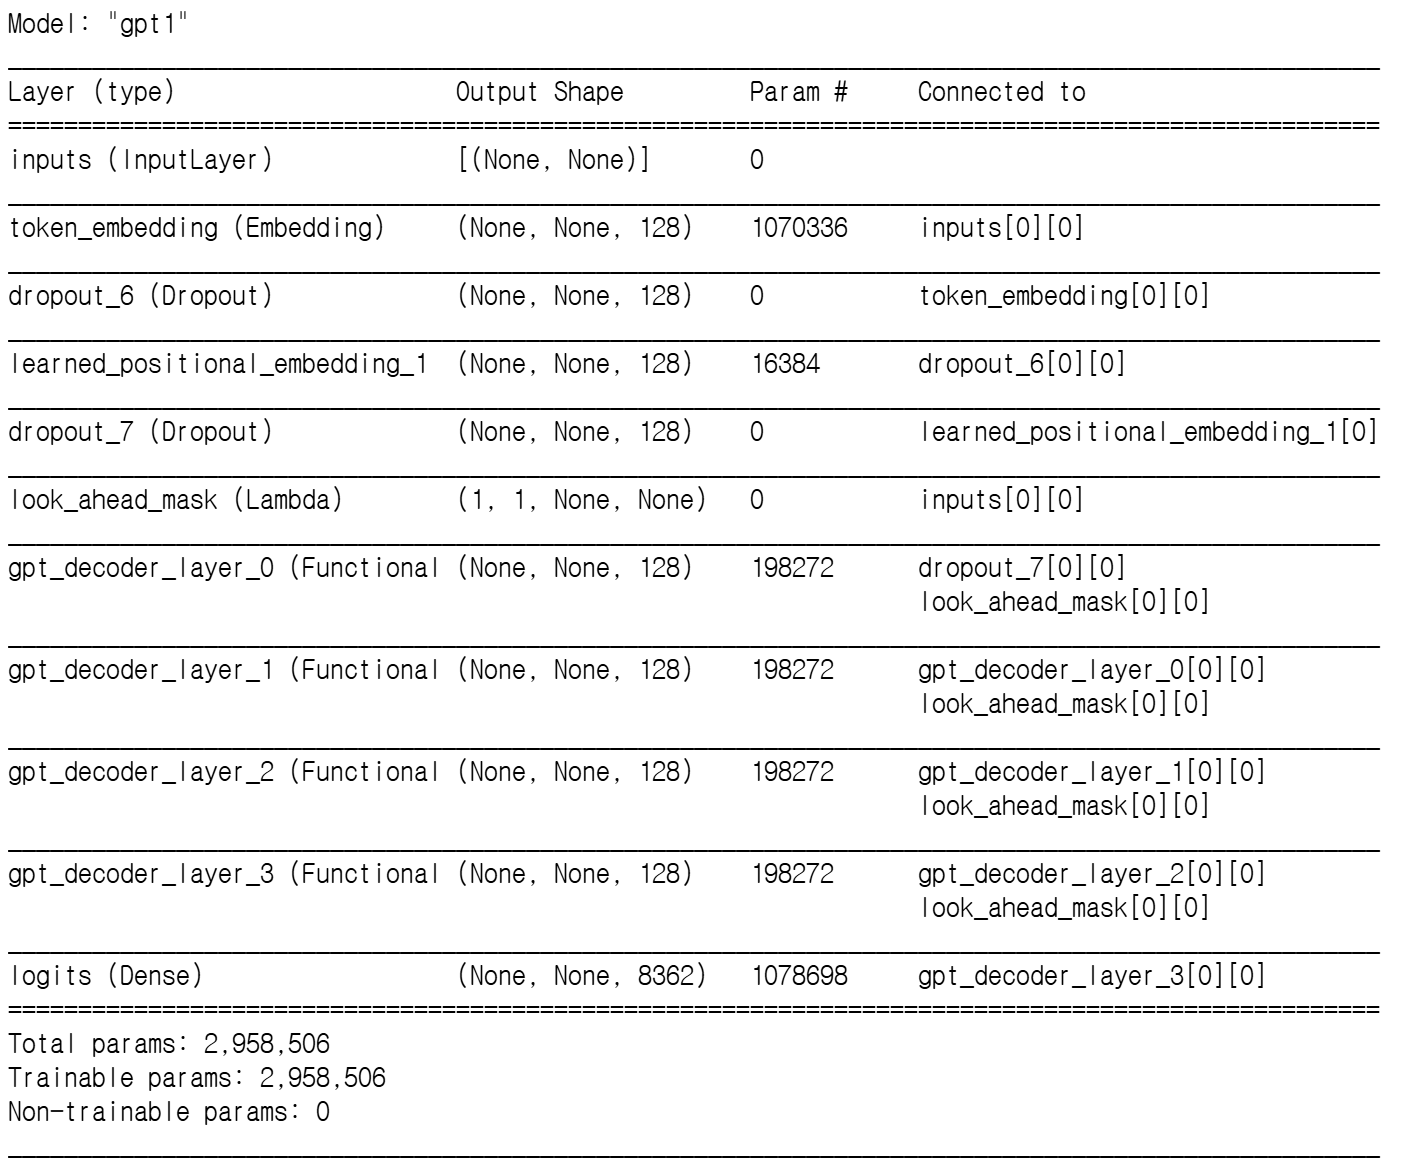

# model.fit 결과
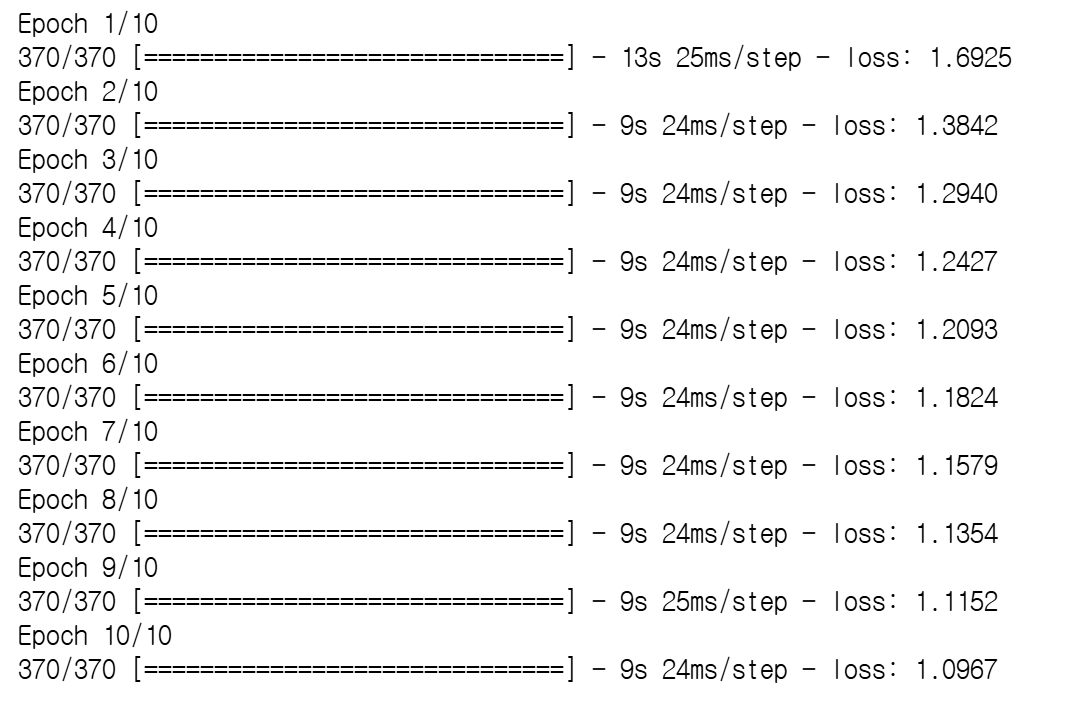

# 라이브러리 불러오기

In [23]:
import os
import re
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
import unicodedata

# 데이터 불러오기

In [24]:
data_path = os.path.expanduser("~/aiffel/transformer_chatbot/data/ChatbotData.csv")
try:
    df = pd.read_csv(data_path, encoding="utf-8")
    print("데이터 로드 완료.")
    print(df.head())
except Exception as e:
    print("데이터 로드 실패:", e)

데이터 로드 완료.
                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0


# Q/A 모두 하나의 문장으로 만들기

- 기존과 다르게, Q/A를 하나의 문장으로 만든 후 전처리를 진행했다.
- seq2seq 방식이 아니기 때문에, 나눌 필요가 없다.

In [48]:
merged_lines = []
for i, row in df.iterrows():
    q = str(row['Q']).strip()
    a = str(row['A']).strip()
    # GPT-1 학습용으로 한 문장으로 합침
    merged_text = f"User: {q} Bot: {a}"
    merged_lines.append(merged_text)

print("예시 merged_lines[0]:", merged_lines[0])

예시 merged_lines[0]: User: 12시 땡! Bot: 하루가 또 가네요.


# 토크나이저 만들기

In [26]:
#
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    merged_lines,
    target_vocab_size=2**13  
)
vocab_size = tokenizer.vocab_size
print("서브워드 단어장 크기:", vocab_size)

서브워드 단어장 크기: 8362


# 학습을 위한 데이터 구성

In [27]:
#Transformer에서와 다르게, Auto-regressive 방식의 GPT를 학습시키기 위해, 동일한 시퀀스에서 한 토큰씩 이동하며 입력 - 레이블을 만든다

def make_ar_slices_from_text(text, tokenizer, max_seq_len=64):
    """
    text: "User: ... Bot: ..." 형태의 한 문장
    tokenizer: 서브워드 토크나이저
    max_seq_len: 한 시퀀스 최대 길이
    return: (inputs_list, labels_list) 여러 시퀀스가 나올 수 있음
    """
    token_ids = tokenizer.encode(text)
    results_in = []
    results_lb = []
    idx = 0
    while idx < len(token_ids):
        chunk = token_ids[idx: idx + max_seq_len]
        if len(chunk) < 2:
            break
        in_seq = chunk[:-1]
        lb_seq = chunk[1:]
        results_in.append(in_seq)
        results_lb.append(lb_seq)
        idx += max_seq_len
    return results_in, results_lb

In [49]:
MAX_SEQ_LEN = 64

all_inputs, all_labels = [], []

for text in merged_lines:
    in_list, lb_list = make_ar_slices_from_text(text, tokenizer, MAX_SEQ_LEN)
    all_inputs.extend(in_list)
    all_labels.extend(lb_list)

print("생성된 (input, label) 쌍 개수:", len(all_inputs))

# 패딩
all_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    all_inputs, maxlen=MAX_SEQ_LEN-1, padding='post'
)
all_labels = tf.keras.preprocessing.sequence.pad_sequences(
    all_labels, maxlen=MAX_SEQ_LEN-1, padding='post'
)

# tf.data.Dataset
BATCH_SIZE = 32
dataset = tf.data.Dataset.from_tensor_slices((all_inputs, all_labels))
dataset = dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)


생성된 (input, label) 쌍 개수: 11823
<BatchDataset shapes: ((32, 63), (32, 63)), types: (tf.int32, tf.int32)>


In [50]:
dataset = tf.data.Dataset.from_tensor_slices((all_inputs, all_labels))
dataset = dataset.shuffle(10000).batch(32)
print(dataset)

<BatchDataset shapes: ((None, 63), (None, 63)), types: (tf.int32, tf.int32)>


# GPT - 1 구현

## 1. 학습가능한 포지셔널 임베딩

In [51]:
class LearnedPositionalEmbedding(tf.keras.layers.Layer):
    """
    transformer에서 사용되는 Positional Encodinf이 아닌
    GPT-1에서 사용되는 학습가능한 Positional Embedding
    (max_position, d_model) 형태의 파라미터를 만들어,
    입력 임베딩(x)에 더해줌
    """
    def __init__(self, max_position, d_model, **kwargs):
        super().__init__(**kwargs)
        self.pos_embedding = self.add_weight(
            name="pos_embedding",
            shape=(max_position, d_model),
            initializer="random_normal",
            trainable=True
        )

    def call(self, x):
        """
        x.shape: (batch_size, seq_len, d_model)
        """
        seq_len = tf.shape(x)[1]
        pos_embed_slice = self.pos_embedding[:seq_len, :]  # (seq_len, d_model)
        pos_embed_slice = tf.expand_dims(pos_embed_slice, 0)  # (1, seq_len, d_model)
        return x + pos_embed_slice

## 2. Attention

In [31]:
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    if mask is not None:
        logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, value)
    return output

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads
        self.query_dense = tf.keras.layers.Dense(d_model)
        self.key_dense = tf.keras.layers.Dense(d_model)
        self.value_dense = tf.keras.layers.Dense(d_model)
        self.final_dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        # x: (batch_size, seq_len, d_model)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.final_dense(concat_attention)
        return output

def create_look_ahead_mask(inputs):
    # inputs: (batch_size, seq_len)
    seq_len = tf.shape(inputs)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    look_ahead_mask = tf.reshape(look_ahead_mask, (1, 1, seq_len, seq_len))
    return look_ahead_mask

## 3. 디코더 구성
- GPT는 인코더 없이 디코더 만으로 구성하여 Cross-Attention을 제거했다.

In [32]:
def gpt_decoder_layer(units, d_model, num_heads, dropout, name="gpt_decoder_layer"):
    """
    (Masked) Self-Attention + Feed Forward 레이어
    """
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

    # 1) Self-Attention
    attention = MultiHeadAttention(d_model, num_heads)(
        {
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        }
    )
    attention = tf.keras.layers.Dropout(dropout)(attention)
    out1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 2) Feed Forward
    ffn_output = tf.keras.layers.Dense(units, activation='relu')(out1)
    ffn_output = tf.keras.layers.Dense(d_model)(ffn_output)
    ffn_output = tf.keras.layers.Dropout(dropout)(ffn_output)
    out2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    return tf.keras.Model(inputs=[inputs, look_ahead_mask], outputs=out2, name=name)

In [33]:
def gpt_model(vocab_size,
              max_position,
              num_layers,
              units,
              d_model,
              num_heads,
              dropout=0.1,
              name="gpt1"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")  # (batch_size, seq_len)

    # Look-Ahead Mask
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask'
    )(inputs)

    # 1) Token Embedding
    token_emb = tf.keras.layers.Embedding(vocab_size, d_model, name="token_embedding")(inputs)
    token_emb = tf.keras.layers.Dropout(dropout)(token_emb)

    # 2) Positional Embedding
    pos_emb_layer = LearnedPositionalEmbedding(max_position, d_model)
    x = pos_emb_layer(token_emb)
    x = tf.keras.layers.Dropout(dropout)(x)

    # 3) 여러 Decoder Layers
    for i in range(num_layers):
        x = gpt_decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name=f"gpt_decoder_layer_{i}"
        )([x, look_ahead_mask])

    # 4) vocab 크기 Dense
    logits = tf.keras.layers.Dense(vocab_size, name="logits")(x)

    return tf.keras.Model(inputs=inputs, outputs=logits, name=name)

In [36]:
# 하이퍼파라미터
NUM_LAYERS = 4
D_MODEL = 128
NUM_HEADS = 4
UNITS = 512
DROPOUT = 0.1
MAX_POSITION = 128

model = gpt_model(
    vocab_size=vocab_size,
    max_position=MAX_POSITION,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

model.summary()

Model: "gpt1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
token_embedding (Embedding)     (None, None, 128)    1070336     inputs[0][0]                     
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, None, 128)    0           token_embedding[0][0]            
__________________________________________________________________________________________________
learned_positional_embedding_1  (None, None, 128)    16384       dropout_6[0][0]                  
_______________________________________________________________________________________________

In [37]:
# 손실 함수
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(y_true, y_pred):
    # y_true, y_pred shape: (batch_size, seq_len)
    loss_ = loss_object(y_true, y_pred)
    # padding mask
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss_ *= mask
    return tf.reduce_mean(loss_)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss_function
)

EPOCHS = 10
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/10
370/370 [==============================] - 13s 25ms/step - loss: 1.6925
Epoch 2/10
370/370 [==============================] - 9s 24ms/step - loss: 1.3842
Epoch 3/10
370/370 [==============================] - 9s 24ms/step - loss: 1.2940
Epoch 4/10
370/370 [==============================] - 9s 24ms/step - loss: 1.2427
Epoch 5/10
370/370 [==============================] - 9s 24ms/step - loss: 1.2093
Epoch 6/10
370/370 [==============================] - 9s 24ms/step - loss: 1.1824
Epoch 7/10
370/370 [==============================] - 9s 24ms/step - loss: 1.1579
Epoch 8/10
370/370 [==============================] - 9s 24ms/step - loss: 1.1354
Epoch 9/10
370/370 [==============================] - 9s 25ms/step - loss: 1.1152
Epoch 10/10
370/370 [==============================] - 9s 24ms/step - loss: 1.0967


In [43]:
import numpy as np
import tensorflow as tf

def generate_text_topk(model, tokenizer, prompt, 
                       max_length=50, 
                       top_k=40, 
                       temperature=1.0):
    """
    model: GPT모델
    tokenizer: tfds.SubwordTextEncoder 등
    prompt: 시작 문장
    max_length: 최대 생성할 토큰 수
    top_k: 상위 k개 토큰만 후보로 삼는 파라미터
    temperature: 로짓을 조절하는 온도 값
    return: 생성된 텍스트
    """

    # 1) 프롬프트를 토큰 시퀀스로 변환
    prompt_ids = tokenizer.encode(prompt)
    generated_ids = prompt_ids[:]  # 복사

    for _ in range(max_length):
        # (1, seq_len) 형태로 모델 입력
        input_array = tf.expand_dims(generated_ids, 0)  # shape: (1, seq_len)
        
        # 모델 예측: (1, seq_len, vocab_size)
        outputs = model(input_array, training=False)
        
        # 마지막 시점의 로짓(logits) 꺼내기: shape = (vocab_size,)
        logits = outputs[:, -1, :]  # (1, vocab_size)
        logits = logits[0].numpy()  # 텐서 -> 넘파이 (vocab_size,)

        # ---- temperature 적용 ----
        if temperature != 1.0:
            logits = logits / temperature

        # ---- top_k 필터링 ----
        if top_k > 0:
            # 1) logits가 큰 순으로 정렬된 인덱스
            sorted_indices = np.argsort(logits)[::-1]
            # 2) 상위 k개만 남기고 나머지는 마스킹(매우 작은 값으로)
            sorted_indices_k = sorted_indices[:top_k]
            
            new_logits = np.full_like(logits, -1e9)  # 기본 -1e9
            for i in sorted_indices_k:
                new_logits[i] = logits[i]
            
            # softmax로 확률 분포 변환
            probs = tf.nn.softmax(new_logits).numpy()
        else:
            # top_k <= 0이면, 그냥 softmax(샘플링)
            probs = tf.nn.softmax(logits).numpy()
        
        # ---- 확률적으로 토큰 샘플링 ----
        next_token_id = np.random.choice(len(probs), p=probs)

        # 시퀀스에 추가
        generated_ids.append(next_token_id)

        # (옵션) 종료 토큰을 정의했다면 break 조건 달 수도 있음
        # if next_token_id == END_TOKEN:
        #     break
    
    # 전체 토큰 시퀀스를 문자열로 디코딩
    output_text = tokenizer.decode(generated_ids)
    return output_text

In [45]:
prompt = "User: 오늘 기분이 어때? Bot:"
result = generate_text_topk(model, tokenizer, prompt,
                            max_length=50,
                            top_k=40,
                            temperature=1.0)
print("=== Generated ===")
print(result)

=== Generated ===
User: 오늘 기분이 어때? Bot:? Bot: 잘 오세요.있어요.생각해보세요Bot: 얼른 있잖아요.좋아요.좋을 거예요.있을 거예요.없어요.더 중요해요.좋을 거예요....있을 거예요.있어요.뙅.있는 것 .좋아하는 때가 있어요.너무 
